In [1]:
%%configure -f
{"driverMemory": "6000M"}

In [2]:
import hail as hl
hl.init(sc)

Starting Spark application


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

pip-installed Hail requires additional configuration options in Spark referring
  to the path to the Hail Python module directory HAIL_DIR,
  e.g. /path/to/python/site-packages/hail:
    spark.jars=HAIL_DIR/hail-all-spark.jar
    spark.driver.extraClassPath=HAIL_DIR/hail-all-spark.jar
    spark.executor.extraClassPath=./hail-all-spark.jarRunning on Apache Spark version 3.1.2-amzn-0
SparkUI available at 
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.80-4ccfae1ff293
LOGGING: writing to

In [3]:
validation_30x_uri= "SG10K-SV-Release-1.4-30x-validation.mt"

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
mt = hl.read_matrix_table(validation_30x_uri)

mt.describe()
mt.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
----------------------------------------
Row fields:
    'locus': locus<GRCh38>
    'alleles': array<str>
    '_old_sv_id': str
    'qual': float64
    'filters': set<str>
    'callers_info': struct {
        manta: struct {
            ABHet: float64, 
            ABHom: float64, 
            ABHetMulti: array<float64>, 
            ABHomMulti: array<float64>, 
            AC: array<int32>, 
            AF: array<float64>, 
            AN: int32, 
            CR: int32, 
            END: int32, 
            HOMSEQ: array<str>, 
            INV3: bool, 
            INV5: bool, 
            LEFT_SVINSSEQ: array<str>, 
            LOGF: float64, 
            MaxAAS: array<int32>, 
            MaxAASR: array<float64>, 
            MaxAltPP: int32, 
            MQ: int32, 
            MQsquared: int32, 
            NCLUSTERS: int32, 
            NGT: array<i

In [5]:
# add metadata
release14_sample_metadata_uri = "2021_06_18_supplier_metadata.n10714_replacespace.txt"

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
### import metadata
t = hl.import_table(release14_sample_metadata_uri, delimiter="\t", quote="\"", impute=True)
#t.describe()

## annotate the hail mt with metadata
t = t.rename({"NPM_Research_ID" : "s"})
t = t.key_by(t.s)
mt = mt.annotate_cols(metadata = t[mt.s])
mt.describe()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
    'metadata': struct {
        Multiplex_Pool_ID: str, 
        Supplier_ID: str, 
        GIS_Internal_Sample_ID: str, 
        Site_Supplying_Sample: str, 
        Year_Of_Birth: int32, 
        Supplied_Gender: str, 
        Self_Reported_Ethnicity: str, 
        Extraction_Kit: str, 
        Date_Of_DNA_Extraction: str, 
        Plate_Position: str, 
        Plate_Name: str, 
        Version_Of_Consent_Form_Signed: str, 
        Sequencing_Depth: str, 
        NPM_Research_ID_Created_By_Username: str, 
        NPM_Research_ID_Creation_Date: str, 
        Comments_Entered_When_NPM_Research_ID_Created: str, 
        Description_Entered_When_NPM_Research_ID_Created: str, 
        ELM_Project_ID: str, 
        ELM_Project_Title: str, 
        ELM_Project_PI: str, 
        Species_Of_Sample_Sequenced: str, 
        Tehcnique_For_Sequencing: str, 
      

In [7]:
mt = hl.variant_qc(mt)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
df = mt.select_rows(
    svtype = mt.callers_info.SVTYPE,
    ac = mt.variant_qc.AC[1]
).rows().select('svtype', 'ac').to_pandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
df2 = df.drop(['locus.contig', 'locus.position', 'alleles'], axis=1)
df2

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

      svtype   ac
0        DUP   28
1        DUP   32
2        DUP  247
3        DUP   95
4        DUP   87
...      ...  ...
60710    DUP   23
60711    DUP    9
60712    DUP  973
60713    DUP   33
60714    DUP    2

[60715 rows x 2 columns]

In [10]:
%%sh
pip install boto3

In [11]:
import boto3
import io
import matplotlib.pyplot as plt
import seaborn as sns

def save_fig_to_s3(fig, bucket, key):
    img_data = io.BytesIO()
    fig.savefig(img_data, format='svg', dpi=300)
    img_data.seek(0)

    s3 = boto3.client('s3')
    response = s3.put_object(Bucket=bucket, Key=key, Body=img_data, ContentType='image/svg')
    print(response)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
import pandas as pd
import matplotlib.pyplot as plt


df = (mt
      #.filter_rows((hl.is_missing(mt.info.manta.PASS_GT2_filter)) | (mt.info.manta.PASS_GT2_filter=="PASS"), keep=True)
      .select_rows(svtype = mt.callers_info.SVTYPE, 
                   ac = mt.variant_qc.AC[1])
      .rows()
      .select('svtype', 'ac')
      .to_pandas()
     )

# Separate 'ac' values for DEL and DUP SV types
ac_del = df[df['svtype'] == 'DEL']['ac']
ac_dup = df[df['svtype'] == 'DUP']['ac']
ac_ins = df[df['svtype'] == 'INS']['ac']

# Calculate cumulative distributions for DEL and DUP SV types
ac_del_counts = ac_del.value_counts().sort_index()
ac_dup_counts = ac_dup.value_counts().sort_index()
ac_ins_counts = ac_ins.value_counts().sort_index()

cum_dist_del = ac_del_counts.cumsum() / ac_del_counts.sum()
cum_dist_dup = ac_dup_counts.cumsum() / ac_dup_counts.sum()
cum_dist_ins = ac_ins_counts.cumsum() / ac_ins_counts.sum()


# Plot cumulative distribution of allele counts (ac)
plt.figure(figsize=(8, 6))
plt.plot(cum_dist_del.index, cum_dist_del.values, label='DEL', marker='', linestyle='-')
plt.plot(cum_dist_dup.index, cum_dist_dup.values, label='DUP', marker='', linestyle='-')
plt.plot(cum_dist_ins.index, cum_dist_ins.values, label='INS', marker='', linestyle='-')

plt.title('Cumulative Distribution Plot of Alt Allele Count (AC)')
plt.xlabel('Alt Allele Count (AC)')
plt.ylabel('Fraction of samples')
plt.xscale('log')  # Set x-axis to log scale (base 10)
#plt.yscale('log')  # Set x-axis to log scale (base 10)

#plt.xlim(left=1)  # Ensure x-axis starts from 1 (log scale)
#plt.xlim(left=0)  # Ensure x-axis starts from 0
#plt.ylim(bottom=0, top=1)  # Set y-axis limits between 0 and 1
plt.legend()

plt.grid(True)
plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

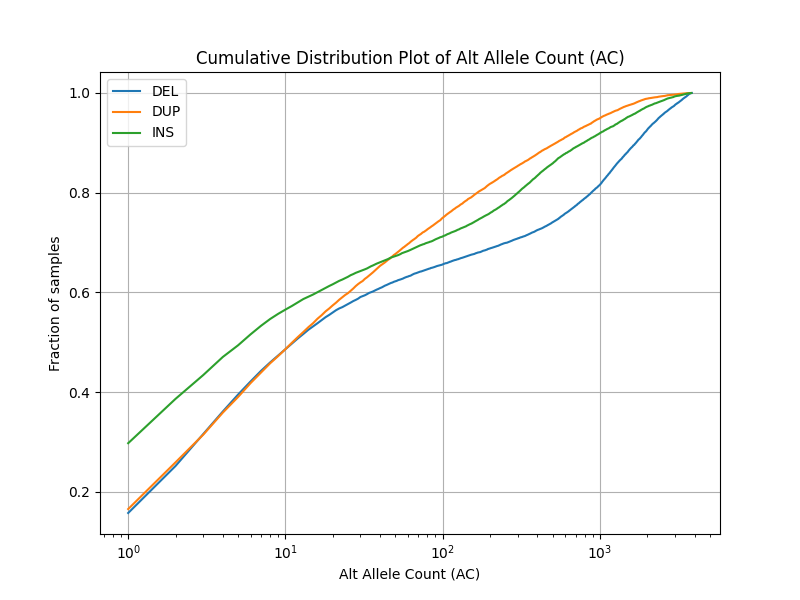

In [13]:
%matplot plt

In [14]:
save_fig_to_s3(plt, "Figures", "SupplementaryFig/30x_validation_acdistribution.svg")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
mt2 = mt.annotate_rows(
    AF_class = hl.case()
            .when((mt.variant_qc.AF[1] < 0.001),  "Ultra-rare")
            .when((mt.variant_qc.AF[1] >= 0.001) & (mt.variant_qc.AF[1] < 0.01), "Rare")
            .when((mt.variant_qc.AF[1] >= 0.01), "Common")
            .default("NA") 
)
mt2.describe()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
    'metadata': struct {
        Multiplex_Pool_ID: str, 
        Supplier_ID: str, 
        GIS_Internal_Sample_ID: str, 
        Site_Supplying_Sample: str, 
        Year_Of_Birth: int32, 
        Supplied_Gender: str, 
        Self_Reported_Ethnicity: str, 
        Extraction_Kit: str, 
        Date_Of_DNA_Extraction: str, 
        Plate_Position: str, 
        Plate_Name: str, 
        Version_Of_Consent_Form_Signed: str, 
        Sequencing_Depth: str, 
        NPM_Research_ID_Created_By_Username: str, 
        NPM_Research_ID_Creation_Date: str, 
        Comments_Entered_When_NPM_Research_ID_Created: str, 
        Description_Entered_When_NPM_Research_ID_Created: str, 
        ELM_Project_ID: str, 
        ELM_Project_Title: str, 
        ELM_Project_PI: str, 
        Species_Of_Sample_Sequenced: str, 
        Tehcnique_For_Sequencing: str, 
      

In [16]:
df = mt2.select_rows(
    svtype = mt2.callers_info.SVTYPE,
    afclass = mt2.AF_class,
).rows().select('svtype', 'afclass').to_pandas()
df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

      locus.contig  locus.position     alleles svtype     afclass
0             chr1           54720  [C, <DUP>]    DUP      Common
1             chr1           83963  [A, <DUP>]    DUP      Common
2             chr1           99061  [C, <DUP>]    DUP      Common
3             chr1          600342  [T, <DUP>]    DUP      Common
4             chr1          600743  [T, <DUP>]    DUP      Common
...            ...             ...         ...    ...         ...
60710        chr22        50643858  [A, <DUP>]    DUP      Common
60711        chr22        50643941  [T, <DUP>]    DUP      Common
60712        chr22        50644070  [A, <DUP>]    DUP      Common
60713        chr22        50644090  [G, <DUP>]    DUP      Common
60714        chr22        50702186  [A, <DUP>]    DUP  Ultra-rare

[60715 rows x 5 columns]

In [17]:
df2 = df.drop(['locus.contig', 'locus.position', 'alleles'], axis=1)
df2

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

      svtype     afclass
0        DUP      Common
1        DUP      Common
2        DUP      Common
3        DUP      Common
4        DUP      Common
...      ...         ...
60710    DUP      Common
60711    DUP      Common
60712    DUP      Common
60713    DUP      Common
60714    DUP  Ultra-rare

[60715 rows x 2 columns]

In [18]:
counts_df2= df2.groupby(['svtype', 'afclass']).size().reset_index(name='counts')
counts_df2

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  svtype     afclass  counts
0    DEL      Common    7614
1    DEL        Rare    5572
2    DEL  Ultra-rare    6089
3    DUP      Common   10034
4    DUP        Rare    6518
5    DUP  Ultra-rare    4825
6    INS      Common    6993
7    INS        Rare    4388
8    INS  Ultra-rare    8682

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.clf()
plt.cla()
fig = plt.figure()

palette=[  '#980043' , '#df65b0' , '#d4b9da']
#set seaborn plotting aesthetics

sns.set(rc={'figure.figsize':(15,15)})
sns.set(style='whitegrid')

#create grouped bar chart
sns.barplot(x='svtype', y='counts', hue='afclass', data=counts_df2, palette = palette) 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<AxesSubplot:xlabel='svtype', ylabel='counts'>

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

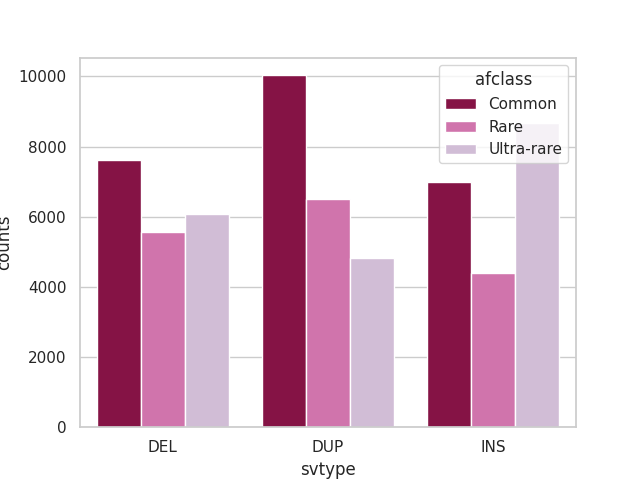

In [20]:
%matplot plt

In [21]:
save_fig_to_s3(plt, "Figures", "SupplementaryFig/30xvalidation_AFcounts_byAFclass_whitegrid.svg")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…